In [1]:
# with open(oname,'r') as f:
#     lines = f.readlines()
import Bio.SearchIO
import scipy.sparse
from domutil.util import *
import subprocess
import sys
did2node = pk_load('hashcath')
# tm,oms = pk_load('1200seq')

matlist = ['bolsum62_logOFquot.mat',
'bolsum62_quotOFlog',
'bolsum62_quotOFlog_atan',
]



/home/shouldsee/.local/lib/python2.7/site-packages/Bio/SearchIO/__init__.py:211: BiopythonExperimentalWarning: Bio.SearchIO is an experimental submodule which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)


In [2]:
from tempfile import TemporaryFile , mkdtemp

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def split_file(fname, number = None, linecount = None, delimiter = '\n', 
               header = '\n', footer = '\n',
               start = 0, end = -1):
    if linecount and number:
        raise Exception('You can only specify one of linecount or number')
    f_handles = []
    tempdir = mkdtemp(prefix = '/tmp/feng')
    
#     lcount = file_len(fname)
    with open(fname,'r') as f:
#         lines = f.readlines()
        lines = f.read().split(delimiter)
        lcount = len(lines)
    print tempdir
    print lcount 
#     return
    
    if number:
#         with open(fname) as f:
#             lines = f.readlines()
        lcount = len(lines)
        nlcount = lcount // number + 1
        idxs = range( 0, lcount , nlcount)
        for i,idx in enumerate(idxs):
#             print i
#             if i >= 11:
#                 break

#             f = TemporaryFile()
            temp_fname = tempdir + '/%d'%i
            f = open(temp_fname, 'w+')
            f.write( header)
            f.write( delimiter.join(lines[idx: idx+nlcount]))
            f.write( footer)
#             f.close()
#             f = open(temp_fname,'r')
#             f.seek(0)
            f_handles.append(temp_fname)
    if linecount:
#         idx = start
        idx = 0
        i   = 0
        nlcount = linecount
        while 1:
            temp_fname = tempdir + '/%d'%i
            f = open(temp_fname, 'w' )
            f.write( header)
            f.write( delimiter.join(lines[idx:idx + nlcount]) )
            f.write( footer)
            f.seek(0)
            f_handles.append(temp_fname)
            if idx + nlcount+1 >= lcount : 
                break
            else:
                idx += nlcount
                i   += 1
    return f_handles
import Bio.SeqIO
def hashfasta(fname):
    it = Bio.SeqIO.parse( fname,'fasta' )
    hash2did = {}
    # i = 0
    for i,ent in enumerate(it):
        h = hash(ent.name) 
        hash2did[ h ] = (i,ent.name)
    return hash2did

def f(oname):
#     it = Bio.SearchIO.parse( oname,'fasta-m10' )
#     d = {}
    it = Bio.SearchIO.parse( oname,'fasta-m10' )
    l = []
    for ent in it:
        hits = ent.__dict__['_items']
        qid = hash(ent.id)
        for hit in hits.values():
            v = hit[0].bitscore
            jid = hash(hit.id)
            l += [((qid,jid),v)]
    #         d[ ( qid, jid) ] = v
    return l

def out2dmat( fname,  hash2did, para = 10,
            qfile  = None,libfile = None,):
    def findheader(fname):
        with open(fname,'r') as f:            
            header = ''
            line = f.readline()
            try:
                while not line.startswith('Query'):
                    header += line
                    line = f.readline()            
                header += line
            except Exception as e:
                raise Exception("Unable to grab the header from file :'%s'"%fname + str(e) )
            buf = f.read()
            tmpf = 'parse.tmp'
            with open( tmpf,'w') as of:
                 of.write(buf)
        return header, tmpf
    if isinstance( fname,list):
        f_handles = fname
        tmpf = ''
    else:
#     if 1:
        header,tmpf = findheader(fname)
#         f_handles = split_file( fname, number = para,
#                        delimiter = '>>><<<',
#                        header = header,
#                        footer = '\n>>>///\n',
#                               start = 10,)
        f_handles = split_file( tmpf, number = para,
#                        delimiter = 'Query',
                        delimiter = '>>><<<',
#                        header = header,
                               header  = header,
                       footer = '\n>>>///\n',
                              start = 0,)
        print header

    xs = []
    ys = []
    if para > 1:
        pool = mp.Pool( para )
        res = pool.map( f, f_handles)
        lst = sum( res,[] )
        d = dict(lst)
        pool.close()
#         pool.join()
    else:
        d  = {}
        i = 0
        print 'handles:',f_handles
        for oname in f_handles:        
            print 'now parsing:',oname
            print i
            i += 1
            it = Bio.SearchIO.parse( oname,'fasta-m10' )
            for ent in it:
            #     print ent
                hits = ent.__dict__['_items']
                qid = hash(ent.id)
                for hit in hits.values():
                    v = hit[0].bitscore
                    jid = hash(hit.id)
                    d[ ( qid, jid) ] = v
#         return d
        
    l = len(hash2did)
    om = scipy.sparse.dok_matrix( (l,l) )
    order_d = { (hash2did[k[0]][0],
                hash2did[k[1]][0]):
               v for k,v in d.iteritems()
              }
    om.update(order_d)
    
    if tmpf:
        os.remove(tmpf)
    for tmpf in f_handles:
        os.remove(tmpf)
    return om
################ old routine ########################
# om.mean()
# tm.mean()
# fname = full("$SEQlib/cath-dataset-nonredundant-S40.fa")
def readfasta( fname ):
    with open(fname, 'r') as f:
        lines =  f.readlines()
    seqs = []
    sfs  = []
    data = []
    for i in range(0,len(lines),2):
        header = lines[i].rstrip('\n')
        seq = lines[i+1].rstrip('\n')
#         acc = p_cathFAheader.findall(header)[0]
#         if not acc in did2node:
#             continue    
#         sf = did2node[acc]
        data.append( (i//2, header, seq) ) 
    return data
def writefasta(fname, data):
    with open(fname,'w') as f:
        for i,header,seq in data:
            f.write( '%s\n%s\n' % (header,seq))

def compare( om, tm = None, thres = 0.5):
    tm = tm.tocsr()
    om = om.tocsr()
    tp = ((om + tm)  == 2).sum()
    fp = ((om - tm)  == 1).sum()
    return tp,fp,



def f2(obj):
    x,y = obj
    v = x[-1] == y[-1]
    return ( (x[0],y[0]), v)
import multiprocessing as mp
def findtm( hash2head, did2node):
    INPUT = list()
    print len(hash2head)
    for i,head in hash2head.itervalues():
        did = p_cathFAheader.findall(head)[0]
        INPUT += [(i,did2node[did])]
    l = len(INPUT)
        # INPUT = hash2did
    it = itertools.combinations( INPUT,2 )
    # it = itertools.combinations( data[:l],2 )
    pool = mp.Pool(12)
    # res = pool.apply_async(f, it)      # runs in *only* one process
    # print res.get(timeout=1)              # prints "400"
    res = pool.map(f2, (it) )
    pool.close()
    pool.join()
    OUTPUT = scipy.sparse.dok_matrix( ( l, l), )
    # OUTPUT.update( res )
    OUTPUT.update({x:y for x,y in res})
    tm = OUTPUT
    return tm
# hash2head

In [3]:
##############################################
### Brew temporary files #####################
##############################################
##############################################
import sys
import os
os.environ['SEQlib'] = '.'
# sys.environs['SEQlib']='.'
forig = full("$SEQlib/cath-dataset-nonredundant-S40.fa")
lnum = 5000
ftmp = forig.rstrip('.fa') + '.%drdtmp'%lnum
data = readfasta( forig )
_ = np.random.seed(0)
# ?np.random.choice
idx = np.random.choice(range(0,len(data)), size = lnum, replace = 0)
# idx = np.random.randint( 0 , len(data), lnum,refill = 0)
writefasta(ftmp, [data[i] for i in idx])


# with open( ftmp,'w' ) as fout:   
#     cmd = 'head -n %d %s' % (lnum,forig,)
#     print cmd
#     subprocess.check_call(cmd.split(),stdout = fout)


In [4]:
%%time
import subprocess
import multiprocessing as mp

matDIR = 'submat/'
matlist = ['blosum62_logOFquot.mat',
'blosum62_quotOFlog.mat',
'blosum62_quotOFlog_atan.mat',
]
DIR = 'result'


fname = ftmp
import multiprocessing as mp
print ftmp
num_T = mp.cpu_count() - 1
# num_T = mp.cpu_count() - 1
num_T = 9


assert os.path.isdir(DIR),'Directory not found:"%s"'%DIR

for matname in matlist:
# for num_T in range(1,14,2):
#     matname = matlist[0]
    print num_T
    print matname
#     mat = 
    cmd = 'fasta36 %s %s -T%d -m10 -f0 -g0 -z5 -E100 -s %s' % (fname,
                                               fname,
                                                num_T,
                                                matDIR + matname)
    print cmd
    oname = os.path.join(DIR,fname  + '_%s.m10' % matname)
    # buf = open()
    with open(oname,'w') as outf:
        %time subprocess.check_call( cmd.split(), stdin=None, stdout=outf, stderr=None, shell=False)


./cath-dataset-nonredundant-S40.5000rdtmp
9
blosum62_logOFquot.mat
fasta36 ./cath-dataset-nonredundant-S40.5000rdtmp ./cath-dataset-nonredundant-S40.5000rdtmp -T9 -m10 -f0 -g0 -z5 -E100 -s submat/blosum62_logOFquot.mat
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 3min 52s
9
blosum62_quotOFlog.mat
fasta36 ./cath-dataset-nonredundant-S40.5000rdtmp ./cath-dataset-nonredundant-S40.5000rdtmp -T9 -m10 -f0 -g0 -z5 -E100 -s submat/blosum62_quotOFlog.mat
CPU times: user 0 ns, sys: 12 ms, total: 12 ms
Wall time: 3min 47s
9
blosum62_quotOFlog_atan.mat
fasta36 ./cath-dataset-nonredundant-S40.5000rdtmp ./cath-dataset-nonredundant-S40.5000rdtmp -T9 -m10 -f0 -g0 -z5 -E100 -s submat/blosum62_quotOFlog_atan.mat
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 3min 51s
CPU times: user 24 ms, sys: 16 ms, total: 40 ms
Wall time: 11min 32s


In [5]:
# %%time
# forig = full("cath-domain-seqs-S35.fa")
# forig = full("cath-dataset-nonredundant-S40.fa")
# ftmp = forig.rstrip('.fa') + '.tmp'
fname = ftmp
hash2head = hashfasta( ftmp )
# forig = full("$SEQlib/cath-dataset-nonredundant-S40.fa")

# forig = full("$SEQlib/cath-domain-seqs-S35.fa")if ncore:
#     fs = split_file('tmp',ncore, delimiter = '>>><<<')
# else:
oms = []
DIR = 'result'
ncore = mp.cpu_count() - 2

matlist = ['blosum62_logOFquot.mat',
'blosum62_quotOFlog.mat',
'blosum62_quotOFlog_atan.mat',
]

for matname in matlist:
    oname = os.path.join(DIR, fname  + '_%s.m10' % matname)
    print oname
    assert os.path.isfile(oname)

    om = out2dmat( oname ,hash2head, para = ncore,
    #              qfile = ftmp,
    #              libfile = ftmp
                 )
    oms += [om]
    print 'Done'

%time tm = findtm( hash2head,did2node )
print 'Done'


result/./cath-dataset-nonredundant-S40.5000rdtmp_blosum62_logOFquot.mat.m10
/tmp/fengcdOyBV
5001
# fasta36 ./cath-dataset-nonredundant-S40.5000rdtmp ./cath-dataset-nonredundant-S40.5000rdtmp -T9 -m10 -f0 -g0 -z5 -E100 -s submat/blosum62_logOFquot.mat
FASTA searches a protein or DNA sequence data bank
 version 36.3.8d Apr, 2016(preload9)
Please cite:
 W.R. Pearson & D.J. Lipman PNAS (1988) 85:2444-2448

Query: ./cath-dataset-nonredundant-S40.5000rdtmp

Done
result/./cath-dataset-nonredundant-S40.5000rdtmp_blosum62_quotOFlog.mat.m10
/tmp/fengLbyY7p
5001
# fasta36 ./cath-dataset-nonredundant-S40.5000rdtmp ./cath-dataset-nonredundant-S40.5000rdtmp -T9 -m10 -f0 -g0 -z5 -E100 -s submat/blosum62_quotOFlog.mat
FASTA searches a protein or DNA sequence data bank
 version 36.3.8d Apr, 2016(preload9)
Please cite:
 W.R. Pearson & D.J. Lipman PNAS (1988) 85:2444-2448

Query: ./cath-dataset-nonredundant-S40.5000rdtmp

Done
result/./cath-dataset-nonredundant-S40.5000rdtmp_blosum62_quotOFlog_atan.mat.m

finished
finished
finished


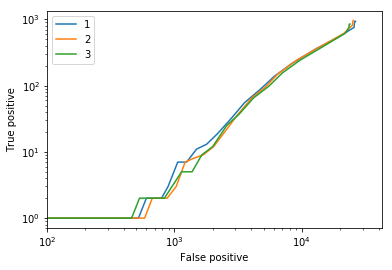

In [6]:
tm = tm.tocsr()
xss = []
yss = []
for om in oms[:]:
#     d = scipy.sparse.dok_matrix( (l,l) )
#     d.update(
#         { (idxD[i],idxD[j]):v for (i,j),v in om.iteritems()}
#     )
#     om = d.tocsr()
    om = om.tocsr()
    thres = 1  
    xs = []
    ys = []
    it = np.linspace( om.min(), om.max(), 100)
    for thres in it:
        tp,fp = compare( om > thres ,tm)
        xs += [fp]
        ys += [tp] 
    xss += [xs]
    yss += [ys]
    print "finished"
    
# compare(tm ,om)
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = plt.subplot(111)
ax1.set_xlabel('False positive')
ax1.set_ylabel('True positive')
ax1.set_xscale('log')
ax1.set_yscale('log')

lbl = 0
for xs,ys in izip(xss,yss):
    lbl += 1
    if lbl ==6:
        break
    ax1.plot(xs,ys, label = lbl)
# ax1.set_ylim(bottom = 40)
# ax1.set_ylim(bottom = 40)
ax1.set_xlim(left = 100)

ax1.legend()

# np.mean(tm.todense())

In [8]:
om.min()

0.0